# Models of Higher Brain Functions - Computer Practical
## 'Learning Dynamics in Deep Linear Networks' - November 2019 - TU Berlin

# Skeleton for Exercise Two:  Deeper (Non-)Linear Networks with AutoDiff

Install PyTorch, for example with conda:
```
conda install pytorch
```
or with pip:
```
pip install torch
```

In [1]:
# Import the required packages
import numpy as np
from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import matplotlib.pyplot as plt

np.random.seed(1)

# Exercise 1: Singular Value Mode Convergence

## 1.

In [2]:
# Constants.
sigma_x = np.eye(4)
first = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [0, 0, 1, 1]])
sigma_xy = np.concatenate([first, np.eye(4)])
dt = 0.1

In [3]:
def update_single_hidden_layer_network(W1, W2, tau, dt):
#     """W1 and W2 will be updated in place."""
    W1 = W1 + (W2.T @ (sigma_xy - W2 @ W1 @ sigma_x)) * dt/tau
    W2 = W2 + (sigma_xy - W2 @ W1 @ sigma_x) @ W1.T * dt/tau
    return W1, W2
    
def update_shallow_network(W_shallow, dt):
#     """W_shallow will be updated in place."""
    W_shallow = W_shallow + (simga_xy - W_shallow @ sigma_x) * dt/tau

## 2.

In [4]:
eta = 0.4
tau = 1/eta
T = 15

mean_ = 0
std_ = 0.1
W1 = np.random.normal(mean_, std_, 64).reshape(16,4)
W2 = np.random.normal(mean_, std_, 112).reshape(7, 16)
W_shallow = np.random.normal(mean_, std_, 28).reshape(7, 4)

In [5]:
all_singular_values = []

for t in range(int(T/dt)):
    W1, W2 = update_single_hidden_layer_network(W1, W2, tau, dt)
#     update_shallow_network(W_shallow, dt)
    
    _, s, _ = np.linalg.svd(W2 @ W1)
    all_singular_values.append(s)

In [6]:
_, sing_val_cov, _ = np.linalg.svd(sigma_xy)
sing_val_cov = sing_val_cov.reshape(4, 1)
sing_val_cov = np.repeat(sing_val_cov, int(T/dt)).reshape(len(sing_val_cov), int(T/dt)).T
sing_val_cov.shape

(150, 4)

(150, 4)


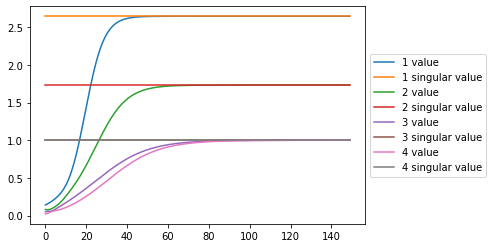

In [13]:
all_singular_values = np.array(all_singular_values)
print(all_singular_values.shape)
for i in range(all_singular_values.shape[1]):
    plt.plot(all_singular_values[:, i], label = f"{i + 1} value")
    plt.plot(sing_val_cov[:, i], label = f"{i + 1} singular value")
    
# plt.plot(sing_val_cov)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Observation**

The singular values of the product of the trained weight matrices converge towards the singular values of sigma_yx.
The convergence rates are different for the singular values: the first value converges the fastest, then the second and the third and fourth value the slowest.

# A. Branching Diffusion Process for Data Generation

The `DiffuseTreeSampler`Class implements a hierarchical data-generation process which we use throughout this exercise (**no need to implement anything from scratch**). A target is generated for all datapoints at a time in a tree-based sequential fashion. A first +/-1 coin flip determines the initial sign of the node at the top of the tree. Afterwards, the tree branches and changes the sign at each stage with a small probability. We repeat this branching process for each layer of the tree. The bottom of the tree corresponds to the value of one feature across the different datapoints. In order to generate multiple target dimensions, the process is repeated for each dimension independently. Finally, we stack them into the overall targets. The input again corresponds to the identity matrix. For more information you can have a look here: https://arxiv.org/pdf/1810.10531.pdf (p. 14). 

In [2]:
class DiffuseTreeSampler():
    def __init__(self, target_dim, tree_depth, branching_factor, sample_epsilon):
        self.target_dim = target_dim
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_target(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        target_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(target_tree[-1], self.branching_factor)
            target_tree.append(next_layer*switch)
        return target_tree[-1]
    
    def sample_data(self):
        """
        Each target dimension diffuses independently of the others!
        """
        targets = []
        for tar in range(self.target_dim):
            target_temp = self.sample_target()
            targets.append(target_temp)
        
        targets_out = np.array(targets).T
        features_out = np.diag(np.ones(self.num_examples))
        return targets_out, features_out

In [3]:
# Create the dataset by instantiating and sampling
hierarchical_tree = DiffuseTreeSampler(target_dim=100, tree_depth=3,
                                       branching_factor=4, sample_epsilon=0.5)
targets, features = hierarchical_tree.sample_data()

print("Output Dimensions: {}".format(targets.shape))
print("Input Dimensions: {}".format(features.shape))

Output Dimensions: (64, 100)
Input Dimensions: (64, 64)


In [4]:
# Calculate the SVD of the covariance matrix
SIGMA_YX = targets.T @ features
U, s, V = svd(SIGMA_YX, full_matrices=True)

# B. PyTorch Example - Feedforward Networks
* Define Neural Network Architecture (single hidden layer ReLU activation)
* Create a Network Instance, Optimizer (stochastic gradient descent) & MSE (mean squared error) Loss
* Perform a forward pass to get predictions, calculate the loss
* Reset the gradients to 0 and perform a backward pass to calculate the gradients + (SGD) update

In [5]:
# Example Feedforward PyTorch Network
class DeepNet(nn.Module):
    """
    Deep Network in PyTorch - Single Hidden Layer with ReLU activation
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim, output_dim):
        super(DeepNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        layers["in_hidden"] = nn.Linear(input_dim, 64, bias=False)
        layers["in_hidden-activation"] = nn.ReLU()
        layers["hidden_out"] = nn.Linear(64, output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [6]:
# Create the network instance, define the learning rate, optimizer & loss
input_dim, output_dim = features.shape[1], targets.shape[1]

l_rate = 0.5
relu_net = DeepNet(input_dim, output_dim)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=l_rate)

mse_loss = nn.MSELoss()

print("The Network Architecture")
print(relu_net)

The Network Architecture
DeepNet(
  (model): Sequential(
    (in_hidden): Linear(in_features=64, out_features=64, bias=False)
    (in_hidden-activation): ReLU()
    (hidden_out): Linear(in_features=64, out_features=100, bias=False)
  )
)


In [7]:
# Perform a forward pass through the network and calculate the loss
input_tensor = torch.tensor(features[0])
y_true = torch.tensor(targets[0]).float()
y_hat = relu_net(input_tensor)
loss = mse_loss(y_hat, y_true)

print("The MSE Loss for the 1st datapoint:{:.3f}".format(loss))  

The MSE Loss for the 1st datapoint:1.003


In [8]:
# Perform a backward pass and update the weights using the SGD optimizer
relu_net.zero_grad()
print("Gradient Sum Input-Hidden Weights after reset: {}".format(relu_net.model.in_hidden.weight.grad))
loss.backward()
print("Gradient Sum Input-Hidden Weights after backward pass: {}".format(relu_net.model.in_hidden.weight.grad.sum()))
relu_optimizer.step()

Gradient Sum Input-Hidden Weights after reset: None
Gradient Sum Input-Hidden Weights after backward pass: 0.11660759150981903


# 1. Code a Variable Depth Linear Network

In [9]:
# TODO: Generalize to variable depth
class DeepLinearNet(nn.Module):
    """
    Deep Network in PyTorch - Single Hidden Layer with ReLU activation
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim=64, output_dim=100, hidden_units=[64]):
        super(DeepNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        layers["in-hidden"] = nn.Linear(input_dim, hidden_units[0], bias=False)
        # TODO: Loop over the hidden layers in the middle to define the full network architecture!
        layers["hidden-out"] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

# 2. Code the Learning Loop for the Linear Network

In [10]:
# TODO: Define the Online Gradient Descent Training Loop
def linear_net_learning(deep_net, mse_loss, optimizer, num_epochs, features, targets):
    """
    Inputs: 'deep_net'   - Instantiated PyTorch Network
            'mse_loss'   - Loss Criterion, i.e. Mean Squared Error
            'optimizer'  - PyTorch Optimizer Object, i.e. Stochastic Gradient Descent
            'num_epochs' - Number of Training Loops over the entire dataset
            'features'   - Training features generated from the sampler
            'targets'    - Training targets generated from the sampler
    Function: Runs the learning loop for the linear network
    """
    loss_log = []
    log_singular_vals = []
    num_points = targets.shape[0]

    for epoch in range(num_epochs):
        epoch_loss = 0
        # TODO: Reshuffle the order of the dataset
        
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            # Extract the current training datapoint and transform it into a Torch Tensor
            input_tensor = torch.tensor(train_items[t])
            y_true = torch.tensor(train_features[t]).float()
                
            # TODO: Compute the prediction for the single datapoint y^hat & the corresponding loss
                     
            # TODO: Clear the gradients, Perform the backward pass, and SGD update
            
            # Update the epoch loss tracker
            epoch_loss += loss.item()
        
        # Log the mean epoch loss & calculate the SVD
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(features)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

# 3. Run the Loop & Plot the singular values

In [11]:
# TODO: Instantiate the network, define the loss & optimizer and run the learning loop

In [12]:
# TODO: Plot the singular values

# 4. Add ReLU Non-Linearities to the Architecture & Repeat

In [13]:
# TODO: Define a new network class that adds a ReLU activation function after each layer.

In [14]:
# TODO: Instantiate the network, define the loss & optimizer and run the learning loop

In [15]:
# TODO: Plot the singular values